# NYC Neighborhood Accessibiliy and Livability Index Clustering

## Intro

Groups New York City neighborhoods (PUMAs) together based on characteristics measuring access and livability.

All data downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

Input Variables:
    
    * Park access: park_access["park_perc"]
    * Job access: job_access["job_perc"]*100/hh_econ["LF_19E"]
    * Access to transit: transit_parks['Percent']
    * Affordable housing: <30% of HH income: 100-housing["GRPI30_19P"],
                          <50% of HH income: 100-housing["GRPI50_19P"]
    * Home ownership: housing["OOcc1_19P"]
    * Broadband access: housing["Comp_19P"]
    * Computer access: housing["BbInt_19P"]
    * Employment rate: hh_econ["CvEm1_19E"]/hh_econ["LF_19E"]
    * Education: Bachelor's degree or higher: hh_econ["Bchpl_19P"]
                 HS graduation rate: 100-hh_econ['HS_19P']
    * Infant mortality: 100-mort_rate["infant_mortality_per1000_16_20"]*10
    * Heat Vulnerability Index: 100-hvi["HVI"]*20

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist, pdist
import scipy.cluster.hierarchy as shc

## Load Data Sets
Downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

In [3]:
path = '../data/'
job_access_path = 'access_to_jobs.csv'
housing_path = 'EDDT_ACS2015-2019.xlsx'
race_dec_path = 'EDDT_Census00-10-20_MUTU.xlsx'
demog_19_path = 'EDDT_Dem_ACS2015-2019.xlsx'
hh_econ_path = 'EDDT_HHEconSec_ACS2015-2019.xlsx'
units_aff_path = 'EDDT_UnitsAffordablebyAMI_2015-2019.xlsx'
dri_path = 'Equitable.Development.Data.Tool.-.Displacement.Risk.Index.2-8-2022.1.xlsx'
park_access_path = 'Park_Access.xlsx'
transit_parks_path = 'EDDE_2023_Updates_transportation.xlsx'
hvi_path = 'HVI_PUMA_Subboro_forSharing.xlsx'
mort_rate_path = 'DOHMH_death rate and overdose.xlsx'

In [4]:
boro_names = ['NYC','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

In [5]:
park_access = pd.read_excel(f'{path}{park_access_path}')
park_access = park_access.loc[~park_access['PUMA'].isin(boro_names)]
park_access.rename(columns={'Perc':'park_perc','PUMA':'PUMA_short'},inplace=True)
park_access['PUMA'] = '360'+park_access['PUMA_short'].astype(str)
park_access.head()

,PUMA_short,Pop_Served,Total_Pop20,park_perc,PUMA
0,3701,104085,113700,91.543536,3603701
1,3702,94287,148709,63.403694,3603702
2,3703,61828,123837,49.926920,3603703
3,3704,110207,130351,84.546340,3603704
4,3705,176653,178035,99.223748,3603705


In [6]:
hh_econ = pd.read_excel(f'{path}{hh_econ_path}')
hh_econ = hh_econ.loc[~hh_econ['Geog'].isin(boro_names)]
hh_econ['PUMA'] = '360'+hh_econ['Geog'].astype(str)
hh_econ.head()

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z,PUMA
6,3701,77539,1586,1.2,100,NaN,14093,1163,5.0,18.2,...,NaN,NaN,NaN,NaN,139284.0,162682.0,71.0,NaN,NaN,3603701
7,3702,101302,1996,1.2,100,NaN,19953,1337,4.1,19.7,...,NaN,NaN,NaN,NaN,13735.0,37476.0,165.9,NaN,NaN,3603702
8,3703,87544,2326,1.6,100,NaN,14779,1623,6.7,16.9,...,120584.0,473.0,NaN,NaN,22498.0,19396.0,52.4,NaN,NaN,3603703
9,3704,88338,1839,1.3,100,NaN,19059,1212,3.9,21.6,...,5042.0,19.7,NaN,NaN,80657.0,29300.0,22.1,NaN,NaN,3603704
10,3705,101379,2083,1.2,100,NaN,34831,1725,3.0,34.4,...,34808.0,111.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3603705


In [8]:
hh_econNYC = pd.read_excel(f'{path}{hh_econ_path}')
hh_econNYC = hh_econNYC.loc[hh_econNYC['Geog']=='NYC']
hh_econNYC.head()

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19E,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z
0,NYC,5935339,4567,0.0,100,NaN,1063104,11063,0.6,17.9,...,19258.0,1010.0,3.2,NaN,NaN,68710.0,4414.0,3.9,NaN,NaN


In [9]:
job_access = pd.read_csv(f'{path}{job_access_path}')
job_access['PUMA'] = job_access['PUMA'].astype(str)
job_access = job_access.loc[~job_access['PUMA'].isin(boro_names)]
job_access = pd.merge(job_access,hh_econ[['PUMA','LF_19E']],how='left',on='PUMA')
# new variable: # of jobs accessible per 100 labor force participants
job_access['job_perc'] = (job_access[
    'Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit']*100)/job_access['LF_19E']
# change values over 100 to 100
job_access['job_perc'] = np.where(job_access['job_perc'] < 100, job_access['job_perc'], 100) 
job_access.head()

,PUMA,Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit,LF_19E,job_perc
0,3603701,45439,50545,89.898111
1,3603702,33763,72051,46.859863
2,3603703,20265,55725,36.366083
3,3603704,53255,60205,88.456108
4,3603705,81569,70950,100.000000


In [10]:
housing = pd.read_excel(f'{path}{housing_path}')
housing = housing.loc[~housing['Geog'].isin(boro_names)]
housing['PUMA'] = '360'+housing['Geog'].astype(str)
housing.head()

,Geog,OcHU1_19E,OcHU1_19M,OcHU1_19C,OcHU1_19P,OcHU1_19Z,OOcc1_19E,OOcc1_19M,OOcc1_19C,OOcc1_19P,...,Comp_A19M,Comp_A19C,Comp_A19P,Comp_A19Z,BbInt_A19E,BbInt_A19M,BbInt_A19C,BbInt_A19P,BbInt_A19Z,PUMA
6,3701,42884,645,0.9,100,NaN,13347,817,3.7,31.1,...,256,10.7,92.9,5.1,1289,236,11.1,82.5,6.0,3603701
7,3702,50543,607,0.7,100,NaN,19234,945,3.0,38.1,...,278,17.9,79.2,16.0,885,240,16.5,74.4,12.2,3603702
8,3703,47805,548,0.7,100,NaN,22513,1265,3.4,47.1,...,278,17.2,75.8,6.9,869,275,19.3,67.1,11.4,3603703
9,3704,44700,549,0.7,100,NaN,13295,810,3.7,29.7,...,340,7.1,90.8,2.3,2389,322,8.2,74.0,5.4,3603704
10,3705,58786,548,0.6,100,NaN,3846,494,7.8,6.5,...,184,34.5,57.4,23.2,310,177,34.6,55.0,22.4,3603705


In [11]:
units_aff = pd.read_excel(f'{path}{units_aff_path}')
units_aff = units_aff.loc[~units_aff['Geog'].isin(boro_names)]
units_aff['PUMA'] = '360'+units_aff['Geog'].astype(str)
units_aff.head()

,Geog,ROcc2_19E,ROcc2_19M,ROcc2_19C,ROcc2_19P,ROcc2_19Z,AfELI_19E,AfELI_19M,AfELI_19C,AfELI_19P,...,AfMidi_19M,AfMidi_19C,AfMidi_19P,AfMidi_19Z,AfHI_19E,AfHI_19M,AfHI_19C,AfHI_19P,AfHI_19Z,PUMA
6,3701,29081,879,1.8,100,NaN,2708,491,11.0,9.3,...,259,15.6,3.5,0.9,159,130.0,49.7,0.5,0.4,3603701
7,3702,30469,1106,2.2,100,NaN,4125,565,8.3,13.5,...,35,77.7,0.1,0.1,12,19.0,98.7,0.0,0.1,3603702
8,3703,24935,1291,3.1,100,NaN,3578,780,13.2,14.3,...,117,47.6,0.6,0.5,33,61.0,111.5,0.1,0.2,3603703
9,3704,30768,959,1.9,100,NaN,3388,447,8.0,11.0,...,118,35.8,0.7,0.4,14,18.0,78.1,0.0,0.1,3603704
10,3705,53565,846,1.0,100,NaN,14696,1130,4.7,27.4,...,61,44.0,0.2,0.1,0,NaN,NaN,NaN,NaN,3603705


In [12]:
race_dec = pd.read_excel(f'{path}{race_dec_path}')
race_dec = race_dec.loc[~race_dec['GeogType'].isin(boro_names)]
race_dec['PUMA'] = ('360'+race_dec['GeoID'].astype(int).astype(str))
race_dec.head()

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P,PUMA
6,PUMA2010,3701.0,113700,100,56187,49.4,34285,30.2,13297,11.7,...,37.4,45378,41.8,14075,13.0,5556,5.1,2960,2.7,3603701
7,PUMA2010,3702.0,148709,100,39442,26.5,8930,6.0,90173,60.6,...,17.5,13783,10.1,90648,66.4,2579,1.9,5474,4.0,3603702
8,PUMA2010,3703.0,123837,100,48297,39.0,31402,25.4,35268,28.5,...,23.4,54501,48.9,26767,24.0,1886,1.7,2306,2.1,3603703
9,PUMA2010,3704.0,130351,100,58209,44.7,26850,20.6,26926,20.7,...,34.7,43076,35.9,23009,19.2,7635,6.4,4640,3.9,3603704
10,PUMA2010,3705.0,178035,100,106163,59.6,7063,4.0,58336,32.8,...,57.3,7689,5.4,48856,34.5,1146,0.8,2848,2.0,3603705


In [14]:
race_decNYC = pd.read_excel(f'{path}{race_dec_path}')
race_decNYC = race_decNYC.loc[race_decNYC['GeogType']=='NYC']
race_decNYC.head()

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P
0,NYC,NaN,8804190,100,2490350,28.3,2719856,30.9,1776891,20.2,...,2160554,27.0,2801267,35.0,1962154,24.5,780229,9.7,304074,3.8


In [15]:
demog_19 = pd.read_excel(f'{path}{demog_19_path}')
demog_19 = demog_19.loc[~demog_19['Geog'].isin(boro_names)]
demog_19['PUMA'] = '360'+demog_19['Geog'].astype(str)
demog_19.head()

,Geog,Pop5p_19E,Pop5p_19M,Pop5p_19C,Pop5p_19P,Pop5p_19Z,LEP_19E,LEP_19M,LEP_19C,LEP_19P,...,P65pl_A19M,P65pl_A19C,P65pl_A19P,P65pl_A19Z,MdAge_A19E,MdAge_A19M,MdAge_A19C,MdAge_A19P,MdAge_A19Z,PUMA
6,3701,102309,2376,1.4,100,NaN,23174,1563,4.1,22.7,...,185,17.1,14.1,3.5,40.2,3.8,5.7,NaN,NaN,3603701
7,3702,140976,2964,1.3,100,NaN,15293,1678,6.7,10.8,...,157,23.0,9.9,2.8,38.8,3.0,4.7,NaN,NaN,3603702
8,3703,113661,3134,1.7,100,NaN,14550,1864,7.8,12.8,...,280,29.6,16.5,7.2,37.5,3.7,6.0,NaN,NaN,3603703
9,3704,118714,2311,1.2,100,NaN,27599,1654,3.6,23.2,...,251,11.1,12.9,1.9,38.6,2.3,3.7,NaN,NaN,3603704
10,3705,156423,2891,1.1,100,NaN,43038,1886,2.7,27.5,...,116,33.7,13.3,6.2,30.0,6.8,13.9,NaN,NaN,3603705


In [16]:
transit_parks = pd.read_excel(f'{path}{transit_parks_path}')
transit_parks['PUMA'] = transit_parks['PUMA'].astype(str)
transit_parks.head()

,PUMA,Pop within 1/4 Mile of Subway Stations and SBS Stops,Total_Pop21,Percent
0,3603701,26984,112474,0.239913
1,3603702,48787,151622,0.321767
2,3603703,15884,119146,0.133315
3,3603704,54384,123579,0.440075
4,3603705,70314,178035,0.394945


In [17]:
mort_rate = pd.read_excel(f'{path}{mort_rate_path}')
mort_rate['PUMA'] = ('360'+mort_rate['PUMA'].astype(str)).str[:7]

mort_rate.head()

,PUMA,infant_mortality_per1000_00_04_W,infant_mortality_per1000_00_04_B,infant_mortality_per1000_00_04_A,infant_mortality_per1000_00_04_H,infant_mortality_per1000_00_04,infant_mortality_per1000_10_14_W,infant_mortality_per1000_10_14_B,infant_mortality_per1000_10_14_A,infant_mortality_per1000_10_14_H,...,overdose_mortality_per100000_00_04,overdose_mortality_per100000_10_14_W,overdose_mortality_per100000_10_14_B,overdose_mortality_per100000_10_14_A,overdose_mortality_per100000_10_14 _H,overdose_mortality_per100000_16_20_W,overdose_mortality_per100000_16_20_B,overdose_mortality_per100000_16_20_A,overdose_mortality_per100000_16_20_H,overdose_mortality_per100000_16_20
0,3603701,*,*,*,6.4,7.5,*,*,*,4.2,...,*,*,*,*,*,21.5,25.8,*,18.3,18.5
1,3603702,0,9.2,*,6.7,8.2,*,7.4,*,7.7,...,*,*,4.5,0,*,58.5,16.5,0,44.2,24.9
2,3603703,*,*,*,*,5.7,*,*,*,*,...,0,22,*,0,*,45.2,12.1,*,25.1,26.8
3,3603704,*,8.9,*,7.4,6.4,*,9.4,*,4.5,...,*,13.9,12.8,*,7.9,33.3,18.3,*,24,22.8
4,3603705,*,11.2,0,5.6,8.1,*,8.4,*,6.9,...,0,77.8,16.4,0,13.5,167.5,60.2,*,38.6,49.2


In [18]:
hvi = pd.read_excel(f'{path}{hvi_path}')
hvi['PUMA'] = '360'+hvi['PUMACE10'].astype(str)
hvi.head()

,PUMACE10,Subboro,HVI,PUMA
0,3701,6,2,3603701
1,3702,10,3,3603702
2,3703,8,1,3603703
3,3704,9,4,3603704
4,3705,2,5,3603705


In [19]:
puma_shape = gpd.read_file(f'{path}NYC_PUMA/geo_export_c1050df7-9a54-46fb-899d-bfbe9cbc5ebf.shp')
puma_shape = puma_shape.to_crs(4326)
puma_shape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792563e+07,53229.056289,"POLYGON ((-73.92161 40.87816, -73.92163 40.878..."
1,3702,1.889969e+08,106050.683760,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3703,2.672936e+08,304849.899974,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062121e+08,47971.694985,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
4,4015,8.105438e+07,50007.415492,"POLYGON ((-73.95375 40.63859, -73.95360 40.638..."


## Data Processing

Input Variables:
    
    * Park access:  park_access["park_perc"]
    * Job access:  job_access["job_perc"]/hh_econ["LF_19E"]
    * Access to transit: transit_parks["Percent"] 
    * Affordable housing:  <30% of HH income: 100-housing["GRPI30_19P"],
                           <50% of HH income: 100-housing["GRPI50_19P"]
    * Home ownership:  housing["OOcc1_19P"]
    * Broadband access:  housing["Comp_19P"]
    * Computer access:  housing["BbInt_19P"]
    * Employment rate:  hh_econ["CvEm1_19E"]/hh_econ["LF_19E"]
    * Education:  Bachelor's degree or higher: hh_econ["Bchpl_19P"]
                  HS graduation rate: hh_econ["HS_19P"]
    * Infant mortality:  100-mort_rate["infant_mortality_per1000_16_20"]*10
    * Heat Vulnerability Index:  100-hvi["HVI"]*20
    

### Create Input Variable Dataframe

In [20]:
data_frames = [park_access[['PUMA','park_perc']], transit_parks[['PUMA','Percent']],
               job_access[['PUMA','job_perc']],
               housing[['PUMA','GRPI30_19P','GRPI50_19P','OOcc1_19P','Comp_19P','BbInt_19P']],
               hh_econ[['PUMA','CvEm1_19E','LF_19E','Bchpl_19P','LtHS_19P']],
               mort_rate[['PUMA','infant_mortality_per1000_16_20']],
               hvi[['PUMA','HVI']]]
df_inputs = reduce(lambda left, right: pd.merge(left, right, on=['PUMA'], how='outer'), data_frames)
df_inputs.head()

,PUMA,park_perc,Percent,job_perc,GRPI30_19P,GRPI50_19P,OOcc1_19P,Comp_19P,BbInt_19P,CvEm1_19E,LF_19E,Bchpl_19P,LtHS_19P,infant_mortality_per1000_16_20,HVI
0,3603701,91.543536,0.239913,89.898111,53.9,29.3,31.1,75.5,73.2,46986.0,50545.0,40.6,18.2,3.38511,2.0
1,3603702,63.403694,0.321767,46.859863,60.7,34.5,38.1,68.2,59.8,65267.0,72051.0,24.4,19.7,6.77924,3.0
2,3603703,49.926920,0.133315,36.366083,49.7,29.4,47.1,73.9,66.2,51509.0,55725.0,26.3,16.9,3.15060,1.0
3,3603704,84.546340,0.440075,88.456108,58.2,30.3,29.7,71.6,60.9,55112.0,60205.0,24.5,21.6,5.05051,4.0
4,3603705,99.223748,0.394945,100.000000,63.9,38.7,6.5,54.6,58.0,62031.0,70950.0,12.8,34.4,6.13354,5.0


In [21]:
df_inputs['Empl_19P'] = df_inputs['CvEm1_19E']*100/df_inputs['LF_19E']
df_inputs['Und30_19P'] = 100-df_inputs['GRPI30_19P']
df_inputs['Und50_19P'] = 100-df_inputs['GRPI50_19P']
df_inputs['diploma'] = 100-df_inputs['LtHS_19P']
df_inputs['subway_sbs'] = 100*df_inputs['Percent']
df_inputs['HVI_inverse'] = 100-20*df_inputs['HVI']
df_inputs['inf_mortality_inverse'] = 100-10*df_inputs['infant_mortality_per1000_16_20']
del df_inputs['GRPI30_19P'], df_inputs['GRPI50_19P'], df_inputs['CvEm1_19E'], df_inputs['LF_19E'], df_inputs['Percent'], df_inputs['LtHS_19P'], df_inputs['HVI'], df_inputs['infant_mortality_per1000_16_20']
df_inputs[['park_perc','job_perc','Empl_19P']] = df_inputs[['park_perc','job_perc','Empl_19P']].round(1)
df_inputs.rename(columns={'OOcc1_19P':'home_own','Comp_19P':'comp_access','BbInt_19P':'broadb_access','Bchpl_19P':'bach_degr',
                          'HS_19P':'diploma','Empl_19P':'empl_rate','Und30_19P':'rent_under30','Und50_19P':'rent_under50'},
                inplace=True)
df_inputs = df_inputs.iloc[:55, :].copy() # remove Na rows
X = df_inputs.iloc[:, 1:] 
df_inputs.head()

,PUMA,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,HVI_inverse,inf_mortality_inverse
0,3603701,91.5,89.9,31.1,75.5,73.2,40.6,93.0,46.1,70.7,81.8,23.991322,60.0,66.1489
1,3603702,63.4,46.9,38.1,68.2,59.8,24.4,90.6,39.3,65.5,80.3,32.176729,40.0,32.2076
2,3603703,49.9,36.4,47.1,73.9,66.2,26.3,92.4,50.3,70.6,83.1,13.331543,80.0,68.4940
3,3603704,84.5,88.5,29.7,71.6,60.9,24.5,91.5,41.8,69.7,78.4,44.007477,20.0,49.4949
4,3603705,99.2,100.0,6.5,54.6,58.0,12.8,87.4,36.1,61.3,65.6,39.494481,0.0,38.6646


In [22]:
X.describe()

,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,HVI_inverse,inf_mortality_inverse
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,81.334545,81.583636,32.367273,75.221818,70.012727,36.950909,93.287273,46.647273,71.005455,81.572727,47.697293,40.000000,61.575364
std,15.841042,27.938767,18.707377,9.070316,8.506513,18.595956,2.513155,7.662918,6.240501,8.708520,23.537248,28.544961,15.425395
min,39.000000,8.000000,3.800000,54.600000,54.900000,12.300000,86.600000,31.900000,55.500000,62.200000,0.000000,0.000000,25.286600
25%,70.350000,65.650000,18.150000,70.750000,62.950000,24.950000,92.050000,41.150000,67.300000,75.500000,33.771047,20.000000,49.437850
50%,83.700000,100.000000,30.800000,75.400000,69.700000,32.600000,93.800000,46.300000,70.700000,82.400000,44.007477,40.000000,60.784300
75%,95.600000,100.000000,43.450000,81.550000,76.600000,42.300000,95.200000,51.050000,74.800000,86.900000,66.068673,60.000000,74.284700
max,100.000000,100.000000,81.500000,93.200000,86.100000,83.500000,96.900000,63.500000,83.900000,97.600000,95.307589,80.000000,88.489900


<AxesSubplot:>

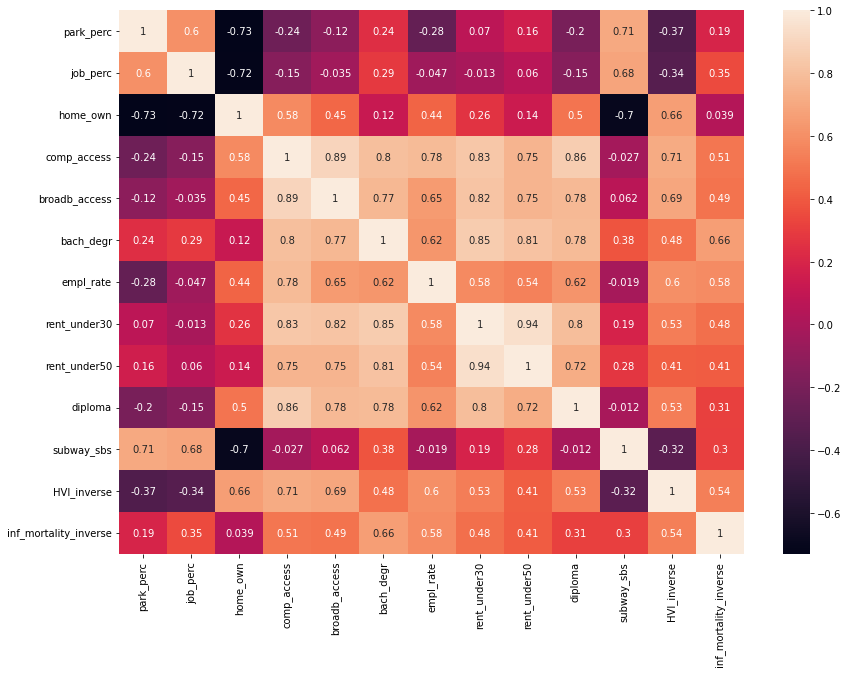

In [23]:
plt.subplots(figsize=(14,10))
sns.heatmap(X.corr(), annot = True)

### Variable Sets

"Condensed" set 1 (8 variables) - park access, job access, computer access, bachelor's degree, employment rate, rent under 30% of HH income, subway and bus access, infant mortality rate

"Condensed" set 2 (8 variables) - park access, job access, computer access, high school diploma, employment rate, rent under 30% of HH income, subway and bus access, infant mortality rate

"Condensed" set 3 (8 variables) - park access, job access, computer access, bachelor's degree, employment rate, rent under 50% of HH income, subway and bus access, infant mortality rate

"Condensed" set 4 (8 variables) - park access, job access, computer access, high school diploma, employment rate, rent under 50% of HH income, subway and bus access, infant mortality rate

In [24]:
cols_1C = ['PUMA','park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse']
cols_2C = ['PUMA','park_perc','job_perc','comp_access','diploma','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse']
cols_3C = ['PUMA','park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under50','subway_sbs','inf_mortality_inverse']
cols_4C = ['PUMA','park_perc','job_perc','comp_access','diploma','empl_rate','rent_under50','subway_sbs','inf_mortality_inverse']

df_1C = df_inputs.loc[:, cols_1C]
C1 = df_1C.iloc[:,1:]
df_2C = df_inputs.loc[:, cols_2C]
C2 = df_2C.iloc[:,1:]
df_3C = df_inputs.loc[:, cols_3C]
C3 = df_3C.iloc[:,1:]
df_4C = df_inputs.loc[:, cols_4C]
C4 = df_4C.iloc[:,1:]
C1.head()

,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse
0,91.5,89.9,75.5,40.6,93.0,46.1,23.991322,66.1489
1,63.4,46.9,68.2,24.4,90.6,39.3,32.176729,32.2076
2,49.9,36.4,73.9,26.3,92.4,50.3,13.331543,68.4940
3,84.5,88.5,71.6,24.5,91.5,41.8,44.007477,49.4949
4,99.2,100.0,54.6,12.8,87.4,36.1,39.494481,38.6646


### Standardization

Not needed for this exercise

Sample code:

In [26]:
scaler = StandardScaler()
scalerNum = scaler.fit(df)
Xstd = scalerNum.transform(df)
df_std = pd.DataFrame(Xstd)

### Silhouette and Elbow Methods:

##### K-Means

In [36]:
master_silhouette_list = []

In [48]:
counter = 0
for df in [C1, C2, C3, C4]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.42423631011888085
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.39022845251825616
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.36078452683822104
For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.3540554667900916
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.2977809682545186
For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.30255584939789454
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.3125662743822465
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.31538881642978317
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.4557108520843486
For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.3000183825228651
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.3524644144301646
For dataset 2 where n_clust

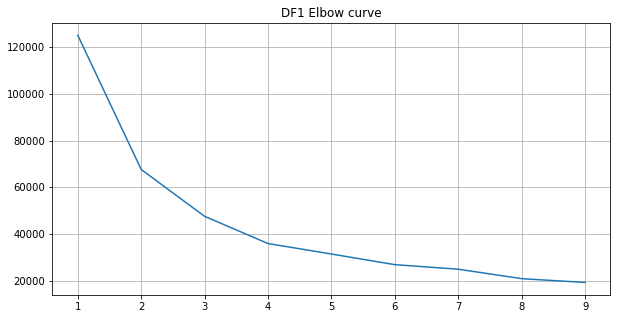

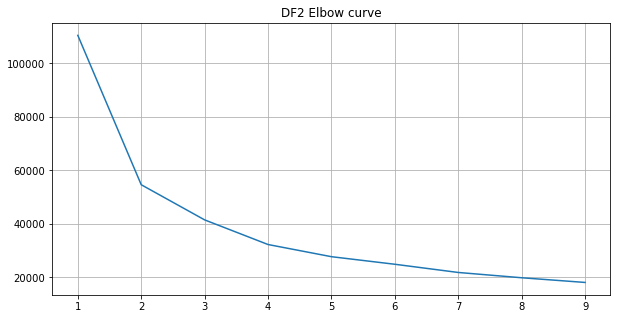

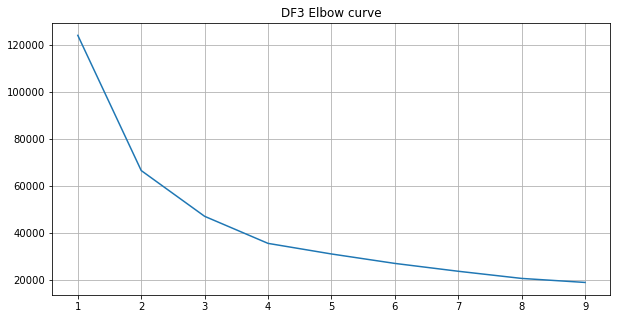

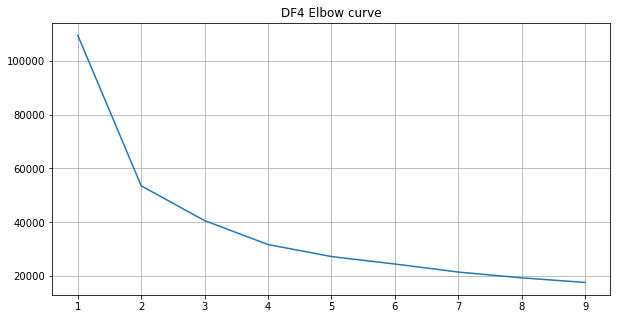

In [51]:
counter = 0
for df in [C1, C2, C3, C4]:
    counter+=1
    distorsions = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        distorsions.append(kmeans.inertia_)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(range(1, 10), distorsions)
    plt.grid(True)
    plt.title(f'DF{counter} Elbow curve')

## Clustering

Based on the Silhouette scores and Elbow coefficients, we'll take the following approach:
    
    * Model: K-means
    * Number of clusters: k=2, k=4

    - For k=2, we'll use: park access, job access, computer access, high school diploma, employment rate, rent under 50% of HH income, subway and bus access, infant mortality rate
    - For k=4, we'll use: park access, job access, computer access, bachelor's degree, employment rate, rent under 30% of HH income, subway and bus access, infant mortality rate

### Trial 1
k=2, dataset 4

In [62]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(C2)
df_2C['labels'] = kmeans.labels_
cluster_sum1 = df_2C.groupby(['labels']).agg({'park_perc':'mean','job_perc':'mean',
                                                 'comp_access':'mean','diploma':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                  'subway_sbs':'mean','inf_mortality_inverse':'mean',
                                             'PUMA':'count'})
cluster_sum1.head()

,park_perc,job_perc,comp_access,diploma,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse,PUMA
labels,,,,,,,,,
0,67.493333,39.493333,76.72,83.113333,93.513333,46.0200,22.260183,51.894540,15
1,86.525000,97.367500,74.66,80.995000,93.202500,46.8825,57.236210,65.205672,40


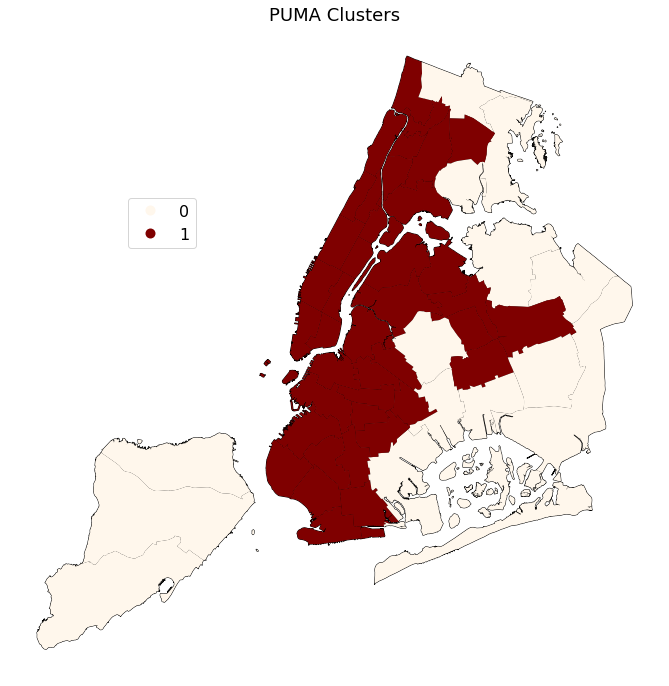

In [88]:
df_2C['puma'] = df_2C['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_2C, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(12,12))
ax = cluster_shapefile.plot(column='labels',categorical=True,legend=True, 
                            legend_kwds={'bbox_to_anchor':(.3, .75),'fontsize':16},
                            cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
plt.title('PUMA Clusters',size=18)
plt.show()

### Trial 2
k=4, dataset 1

In [125]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(C1)
df_1C['labels'] = kmeans.labels_
df_1C.head()

C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,PUMA,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse,labels,puma
0,3603701,91.5,89.9,75.5,40.6,93.0,46.1,23.991322,66.1489,0,3701
1,3603702,63.4,46.9,68.2,24.4,90.6,39.3,32.176729,32.2076,2,3702
2,3603703,49.9,36.4,73.9,26.3,92.4,50.3,13.331543,68.4940,2,3703
3,3603704,84.5,88.5,71.6,24.5,91.5,41.8,44.007477,49.4949,0,3704
4,3603705,99.2,100.0,54.6,12.8,87.4,36.1,39.494481,38.6646,1,3705


In [126]:
cluster_sum2 = df_1C.groupby(['labels']).agg({'park_perc':'mean','job_perc':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'subway_sbs':'mean','inf_mortality_inverse':'mean',
                                             'PUMA':'count'})
cluster_sum2.head()

,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse,PUMA
labels,,,,,,,,,
0,75.547368,95.257895,75.336842,35.921053,94.000000,44.742105,43.734147,67.927079,19
1,96.978571,98.914286,66.264286,28.064286,90.814286,42.971429,67.994487,52.827029,14
2,67.493333,39.493333,76.720000,27.926667,93.513333,46.020000,22.260183,51.894540,15
3,95.414286,100.000000,89.614286,76.857143,95.814286,60.514286,72.368110,82.576286,7


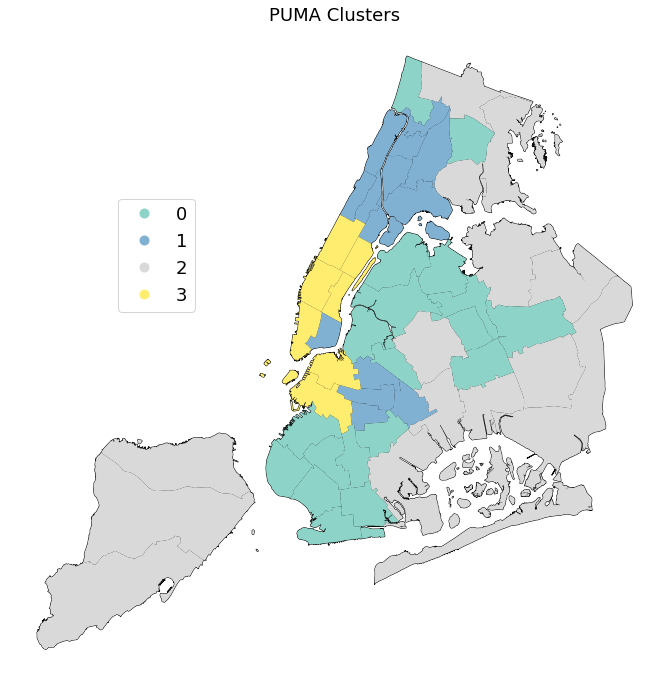

In [127]:
df_1C['puma'] = df_1C['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_1C, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(12,12))
ax = cluster_shapefile.plot(column='labels',categorical=True,legend=True, 
                            legend_kwds={'bbox_to_anchor':(.3, .75),'fontsize':18},
                            cmap='Set3',ax=base)
ax.set_aspect='equal'
ax.axis('off')
plt.title('PUMA Clusters',size=18)
plt.show()

### Result Visualizations/Outputs

In [124]:
demographic_df = pd.merge(hh_econ[["PUMA","MdHInc_19E"]], race_dec[['PUMA','WNH20P','Hsp20P','BNH20P','ANH20P','OTwoNH20P']],
                         on='PUMA', how='inner')
master_cluster_df = pd.merge(df_1C, demographic_df, on='PUMA', how='inner')
master_cluster_df.to_excel('../outputs/cluster_8v_results_full.xlsx',index=False)

In [90]:
inc_df = pd.merge(hh_econ[["PUMA","MdHInc_19E"]],
                  df_1C[['PUMA','labels']], on='PUMA', how='inner')
inc_df.rename(columns={"MdHInc_19E":'Median Income'},inplace=True)

In [91]:
inc_dfNYC = hh_econNYC[["MdHInc_19E"]]
inc_dfNYC.rename(columns={"MdHInc_19E":'Median Income'},inplace=True)
inc_dfNYC['labels']=['NYC']

<ipython-input-91-652a77def6bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_dfNYC['labels']=['NYC']


In [76]:
race_df = pd.merge(race_dec[['PUMA','WNH20P','Hsp20P','BNH20P','ANH20P','OTwoNH20P']],
                   df_1C[['PUMA','labels']], on='PUMA', how='inner')
race_df.rename(columns={"WNH20P":'White NH',"Hsp20P":'Hispanic',"BNH20P":'Black NH',"ANH20P":'Asian NH',
                       "OTwoNH20P":'Multi-Race NH'},inplace=True)

<AxesSubplot:xlabel='labels'>

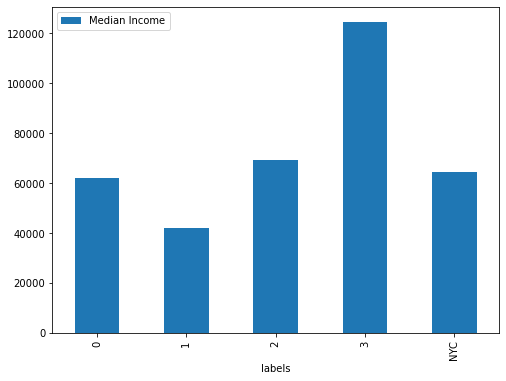

In [98]:
cluster_inc = inc_df.groupby(['labels']).agg({'Median Income':'mean'}).reset_index()
cluster_inc = cluster_inc.append(inc_dfNYC)
cluster_inc.plot.bar(x='labels',figsize=(8,6))

In [77]:
race_dfNYC = race_decNYC[['WNH20P','Hsp20P','BNH20P','ANH20P','OTwoNH20P']]
race_dfNYC.rename(columns={"WNH20P":'White NH',"Hsp20P":'Hispanic',"BNH20P":'Black NH',"ANH20P":'Asian NH',
                       "OTwoNH20P":'Multi-Race NH'},inplace=True)
race_dfNYC['labels']=['NYC']

<ipython-input-77-a0cdcae111da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_dfNYC['labels']=['NYC']


<AxesSubplot:xlabel='labels'>

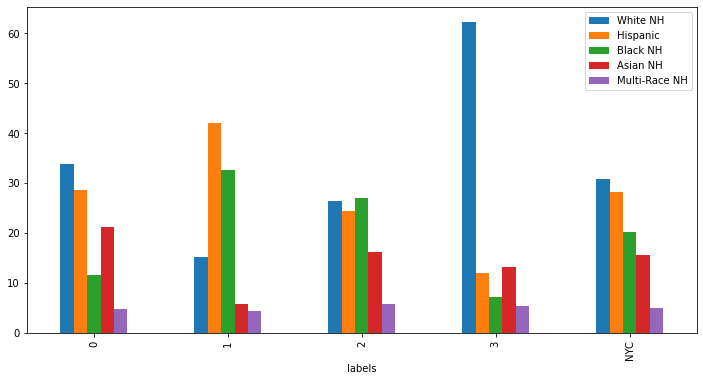

In [87]:
cluster_race = race_df.groupby(['labels']).agg({'White NH':'mean','Hispanic':'mean',
                                                 'Black NH':'mean','Asian NH':'mean',
                                                 'Multi-Race NH':'mean'}).reset_index()
cluster_race = cluster_race.append(race_dfNYC)
cluster_race.plot.bar(x='labels',figsize=(12,6))

In [125]:
cluster_summ = cluster_sum2.reset_index().iloc[:,:9]
cluster_summ

,labels,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse
0,0,95.414286,100.000000,89.614286,76.857143,95.814286,60.514286,72.368110,82.576286
1,1,75.547368,95.257895,75.336842,35.921053,94.000000,44.742105,43.734147,67.927079
2,2,67.493333,39.493333,76.720000,27.926667,93.513333,46.020000,22.260183,51.894540
3,3,96.978571,98.914286,66.264286,28.064286,90.814286,42.971429,67.994487,52.827029


In [133]:
df_inputs = reduce(lambda left, right: pd.merge(left, right, on=['PUMA'], how='outer'), data_frames)

df_inputs['empl_rate'] = df_inputs['CvEm1_19E']*100/df_inputs['LF_19E']
df_inputs['rent_under30'] = 100-df_inputs['GRPI30_19P']
df_inputs['rent_under50'] = 100-df_inputs['GRPI50_19P']
df_inputs['diploma'] = 100-df_inputs['LtHS_19P']
df_inputs['subway_sbs'] = 100*df_inputs['Percent']
del df_inputs['GRPI30_19P'],df_inputs['GRPI50_19P'],df_inputs['CvEm1_19E'],df_inputs['LF_19E'],df_inputs['Percent'],df_inputs['LtHS_19P']
df_inputs[['park_perc','job_perc','empl_rate']] = df_inputs[['park_perc','job_perc','empl_rate']].round(1)
df_inputs.rename(columns={'OOcc1_19P':'home_own','Comp_19P':'comp_access','BbInt_19P':'broadb_access','Bchpl_19P':'bach_degr',
                         'infant_mortality_per1000_16_20':'infant_mortality_per1000'},
                inplace=True)
df_inputs = df_inputs.iloc[:55, :].copy() # remove Na rows
df_inputs['labels'] = kmeans.labels_
df_inputs.head()

,PUMA,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,infant_mortality_per1000,HVI,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,labels
0,3603701,91.5,89.9,31.1,75.5,73.2,40.6,3.38511,2.0,93.0,46.1,70.7,81.8,23.991322,0
1,3603702,63.4,46.9,38.1,68.2,59.8,24.4,6.77924,3.0,90.6,39.3,65.5,80.3,32.176729,2
2,3603703,49.9,36.4,47.1,73.9,66.2,26.3,3.15060,1.0,92.4,50.3,70.6,83.1,13.331543,2
3,3603704,84.5,88.5,29.7,71.6,60.9,24.5,5.05051,4.0,91.5,41.8,69.7,78.4,44.007477,0
4,3603705,99.2,100.0,6.5,54.6,58.0,12.8,6.13354,5.0,87.4,36.1,61.3,65.6,39.494481,1


In [138]:
cluster_sumFin = df_inputs.groupby(['labels']).agg({'park_perc':'mean','job_perc':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'subway_sbs':'mean','infant_mortality_per1000':'mean',
                                             'PUMA':'count'})
cluster_sumFin.to_excel('../outputs/cluster_8v_results_cleaned.xlsx')

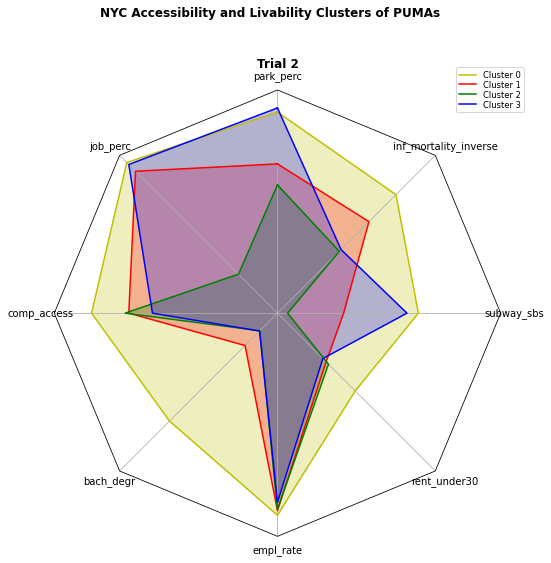

In [142]:
# radar chart code below

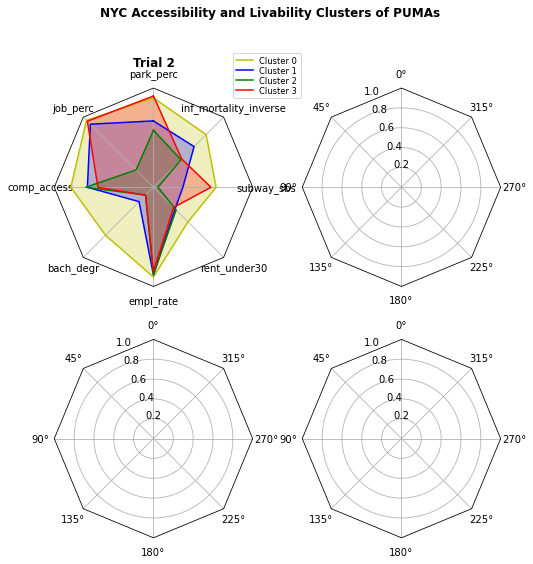

In [106]:
# radar chart code

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='polygon'):
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    class RadarAxes(PolarAxes):
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

def example_data():
    data = [
        ['park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse'],
        ('Trial 2', [
            [95.414286,100.00000,89.614286,76.857143,95.814286,60.514286,72.368110,82.576286],
            [75.547368,95.257895,75.336842,35.921053,94.000000,44.742105,43.734147,67.927079],
            [67.493333,39.493333,76.720000,27.926667,93.513333,46.020000,22.260183,51.894540],
            [96.978571,98.914286,66.264286,28.064286,90.814286,42.971429,67.994487,52.827029],
        ])
    ]
    return data

if __name__ == '__main__':
    N = 8
    title = 'NYC Accessibility and Livability Clusters of PUMAs'
    theta = radar_factory(N, frame='polygon')
    data = example_data()
    spoke_labels = data.pop(0)
    fig, axs = plt.subplots(figsize=(8, 8), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    colors = ['y', 'b', 'g', 'r']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([1, 2, 3, 4, 5, 6, 7])
        ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
    # ['b', 'r', 'g', 'm', 'y', 'c', 'k']
    # Plot the four cases from the example data on separate axes
#     ax.set_rgrids([1, 2, 3, 4, 5, 6, 7, 8])
#     ax.set_title(title, weight='bold', size='large', position=(0.5, 1.1),
#                  horizontalalignment='center', verticalalignment='center')
#     for d, color in zip(data, colors):
#         ax.plot(theta, d, color=color)
#         ax.fill(theta, d, facecolor=color, alpha=0.25)
#     ax.set_varlabels(spoke_labels)
    # add legend relative to top-left plot
    labels = ('Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3')
    legend = ax.legend(labels, loc=(0.9, 0.95),
                              labelspacing=0.1, fontsize='small')
    fig.text(0.5, 0.965, 'NYC Accessibility and Livability Clusters of PUMAs',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.show()